In [1]:
import numpy as np
import pandas as pd
import polars as pl
import pickle
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Draw


import sys
sys.path.append('../')
from src.setup.setup_data import setup_train_x_data, setup_train_y_data, sample_data
from src.typing.xdata import XData, DataRetrieval

# Common Variables

In [2]:
DATA_PATH = Path('../data/')
SHRUNKEN_PATH = DATA_PATH / 'shrunken/'

# check if global variables are defined
if '_x_data' not in globals():
    _x_data = None

if '_y_data' not in globals():
    _y_data = None

if '_train_data' not in globals():
    _train_data = None

# Dataset Utils

In [3]:
def get_x_data() -> XData:
    global _x_data

    if _x_data is not None:
        return _x_data
    
    print('Loading x_data from disk...')
    _x_data = setup_train_x_data(SHRUNKEN_PATH, get_train_data())

    return _x_data

def get_y_data():
    global _y_data

    if _y_data is not None:
        return _y_data

    print('Loading y_data from disk...')
    _y_data = setup_train_y_data(get_train_data())

    return _y_data

def get_train_data(sample_size: int = -1, sample_split: float = 0.5):
    global _train_data

    if _train_data is not None:
        return _train_data

    print('Loading train_data from disk...')
    _train_data = pl.read_parquet(SHRUNKEN_PATH / "train.parquet")
    _train_data = _train_data.to_pandas(use_pyarrow_extension_array=True)

    if sample_size > 0:
        _train_data = sample_data(_train_data, sample_size, sample_split)

    return _train_data

def visualize_molecule(molecule, desc = ""):
    print(desc)
    if isinstance(molecule, str):
        molecule = Chem.MolFromSmiles(molecule)
    molecule_image = Draw.MolToImage(molecule, size=(300, 300))
    display(molecule_image)


# Exploration

In [4]:
from rdkit import Chem
from rdkit.Chem import rdRGroupDecomposition as rgd
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS

Loading train_data from disk...
Loading x_data from disk...
['Cc1ccc([N+](=O)[O-])c(Nc2nc(NCCCOc3cccc(C)c3C)nc(NCC3CCC(C(=O)N[Dy])CC3)n2)n1', 'O=C(NCC1CCC(C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21', 'Cc1cccc(OCCCN)c1C.Cl', 'Cc1ccc([N+](=O)[O-])c(N)n1']


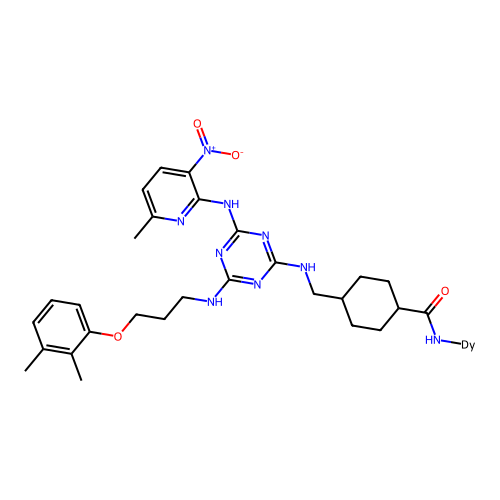

In [5]:
get_train_data(100_000, 0.5)
x = get_x_data()
x.retrieval = DataRetrieval.SMILES

test_smile = x[5_000]
print(test_smile)

mol = Chem.MolFromSmiles(test_smile[0])
display(Draw.MolToImage(mol, size=(500, 500)))

RM Mol


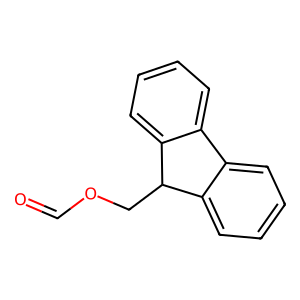

Building Block


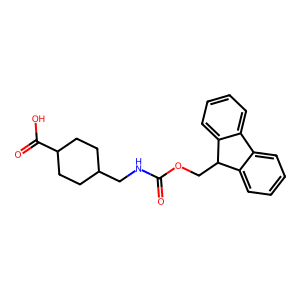

Building Block without RM Mol


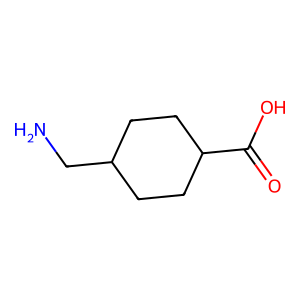

In [6]:
test_mol = [Chem.MolFromSmiles(smiles) for smiles in test_smile]

molecule = test_mol[0]
building_block = test_mol[1]
mcs = rdFMCS.FindMCS([test_mol[0], building_block])
mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
# visualize_molecule(test_mol[0], desc="Molecule")
# visualize_molecule(building_block, desc="Building Block")
# visualize_molecule(mcs_mol, desc="MCS")

rm_smile = "O=C(O)"                # Ester
rm_smile = "O=C(O*)*"               # Ester
rm_smile = "O=COCC1c2ccccc2-c2ccccc21"  # Biphenyl
rm_mol = Chem.MolFromSmiles(rm_smile)
visualize_molecule(rm_mol, desc="RM Mol")

visualize_molecule(building_block, desc="Building Block")

# Remove ester from building block
# building_block = Chem.DeleteSubstructs(building_block, Chem.MolFromSmarts(ester_smile))
# visualize_molecule(building_block, desc="Building Block without Ester")
building_block_smile = Chem.rdmolops.DeleteSubstructs(building_block, rm_mol, onlyFrags=False)
visualize_molecule(building_block_smile, desc="Building Block without RM Mol")

# Remove the MCS from the molecule
# molecule = Chem.DeleteSubstructs(molecule, mcs_mol)
# visualize_molecule(molecule, desc="Molecule without MCS")


Modified SMILES: C.CC


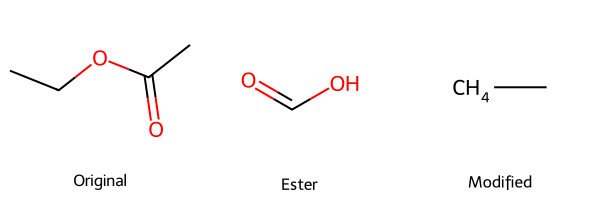

In [8]:
from rdkit import Chem
from rdkit.Chem import Draw

# Correctly specify the ester including context atoms
rm_smile = "C(=O)O"  # General ester group; you might need more context depending on the molecule
rm_mol = Chem.MolFromSmiles(rm_smile)

# Full molecule containing an ester
full_molecule_smiles = "CC(=O)OCC"
full_molecule = Chem.MolFromSmiles(full_molecule_smiles)

# Remove the ester substructure
modified_molecule = Chem.DeleteSubstructs(full_molecule, rm_mol, onlyFrags=False)
print("Modified SMILES:", Chem.MolToSmiles(modified_molecule))

# Visualize the molecules
img = Draw.MolsToGridImage([full_molecule, rm_mol, modified_molecule], molsPerRow=3, subImgSize=(200, 200),
                           legends=['Original', 'Ester', 'Modified'])
display(img)

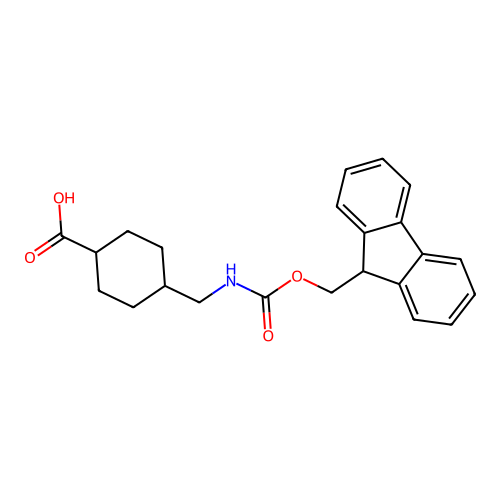

Modified molecule SMILES: CC1c2ccccc2-c2ccccc21.NCCCCCC=O


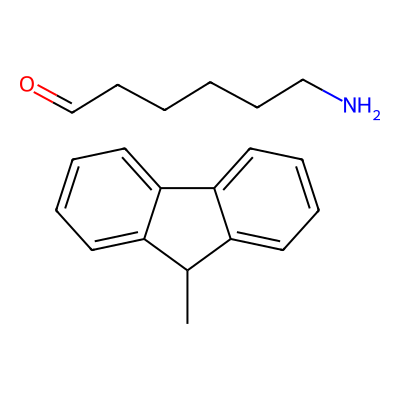

In [9]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

def remove_specific_substructure(molecule_smiles, substructure_smarts):
    mol = Chem.MolFromSmiles(molecule_smiles)
    substructure = Chem.MolFromSmarts(substructure_smarts)

    # Find all matches of the substructure
    matches = mol.GetSubstructMatches(substructure)
    if not matches:
        return Chem.MolToSmiles(mol)  # Return original if no substructure found

    # Sort matches to find the specific one if needed, otherwise just remove all found
    for match in matches:
        # Create editable molecule
        emol = Chem.EditableMol(mol)

        # Delete atoms by reversed index order to not mess up remaining indices
        for idx in sorted(match, reverse=True):
            emol.RemoveAtom(idx)

        # Get the modified molecule
        mol = emol.GetMol()
    
    # Check if the molecule is valid and sanitize it
    if mol:
        Chem.SanitizeMol(mol)
        return Chem.MolToSmiles(mol)

    return "Error in molecule modification"

# Example usage
mol_smiles = 'O=C(NCC1CCC(C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21'
substructure_smarts = 'C(=O)O'  # Basic ester pattern

display(Draw.MolToImage(Chem.MolFromSmiles(mol_smiles), size=(500, 500)))

modified_smiles = remove_specific_substructure(mol_smiles, substructure_smarts)
print("Modified molecule SMILES:", modified_smiles)

# Visualize the modified molecule
modified_mol = Chem.MolFromSmiles(modified_smiles)
img = MolsToGridImage([modified_mol], molsPerRow=1, subImgSize=(400, 400))
display(img)